In [2]:
from google.colab import drive
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
import numpy as np
from sklearn.metrics import f1_score   


drive.mount ('/content/drive')
path = '/content/drive/MyDrive/Final Project/artemis_dataset_release_v0.csv'
data_file = open(path)
data_file = pd.read_csv(data_file)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset


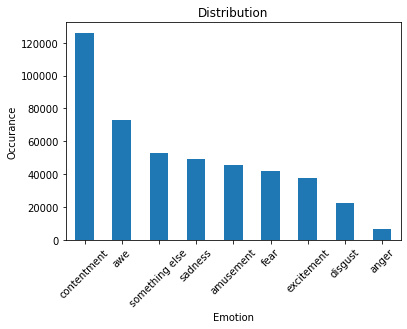

In [3]:
#print(data_file)
#print(data_file["utterance"])
import matplotlib.pyplot as plt

class CustomTextDataset(Dataset):
    def __init__(self, file):
        self.labels = file['emotion']
        self.text = file['utterance']
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.text[idx], self.labels[idx]

ax = data_file['emotion'].value_counts().plot(kind='bar')
plt.xticks(rotation=(45))
plt.title('Distribution')
plt.xlabel('Emotion')
plt.ylabel('Occurance')
plt.plot()

label_dict = {
    "fear": 0, 
    "sadness": 1,
    "anger": 2, 
    "disgust": 3, 
    "contentment":4, 
    "awe": 5, 
    "something else": 6,
    "amusement": 7, 
    "excitement": 8
}

# Tokenize

In [4]:
tokenizer = get_tokenizer('basic_english')
#import nltk
#from nltk.tokenize import sent_tokenize
#nltk.download('punkt')

val_frac = 0.1 
val_split_idx = int(len(data_file)*val_frac) 
data_idx = list(range(len(data_file)))
np.random.shuffle(data_idx)

#get indexes for validation and train
val_idx, train_idx = data_idx[:val_split_idx], data_idx[val_split_idx:]
print('len of train: ', len(train_idx))
print('len of val: ', len(val_idx))

train = data_file.iloc[train_idx].reset_index().drop('index',axis=1)
val = data_file.iloc[val_idx].reset_index().drop('index',axis=1)

print(len(train))

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

def yield_tokens_label(data_iter):
    for text in data_iter:
      #yield sent_tokenize(text)
      yield label_dict[text]

vocab_text = build_vocab_from_iterator(yield_tokens(train["utterance"]), specials=["<unk>", "<pad>"])
vocab_text.set_default_index(vocab_text["<unk>"])

#vocab_label = build_vocab_from_iterator(yield_tokens_label(train["emotion"]), specials=["<unk>"])
#vocab_label.set_default_index(vocab_label["<unk>"])


len of train:  409216
len of val:  45468
409216


In [5]:
text_pipeline = lambda x: vocab_text(tokenizer(x))
label_pipeline = lambda x: vocab_label(sent_tokenize(x))

PAD_TOKEN = vocab_text(tokenizer("<pad>"))
assert len(PAD_TOKEN) == 1
PAD_TOKEN = PAD_TOKEN[0]
print(PAD_TOKEN)

1


# Create Encoder Padding Mask

In [6]:
def padding_mask(batch):
  pad_token_id = 1
  pad_mask = ~(batch != pad_token_id)
  return pad_mask



# Define Train and Evaluate 

In [7]:
import time

def train(model, dataloader, loss_func, device, grad_norm_clip, running_loss):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 1000
    start_time = time.time()

    for idx, (text, label) in enumerate(dataloader):
        label = label.to(device)
        text = text.to(device)
        optimizer.zero_grad()
        
        logits = None
        mask = padding_mask(text)
        logits = model(text, mask)
        #print(logits.shape)
        #print(label)
        label = label.squeeze()
        loss = loss_func(logits, label)
        running_loss += loss.item() * text.size(0)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
        optimizer.step()
        total_acc += (logits.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy score {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

    return running_loss

def evaluate(model, dataloader, loss_func, device):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (text, label) in enumerate(dataloader):
            label = label.to(device)
            text = text.to(device)
            
            logits = model(text)
            f1score_average = f1_score(label.cpu().data, logits.cpu().data.argmax(1), average = 'micro')
            total_acc += (logits.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count, f1score_average

# Batch Collection


In [8]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    label_list, text_list, text_len_list = [], [], []
    for (text) in batch:
        #label_list.append(label_pipeline(text[1]))
        label_list.append(label_dict[text[1]])
        processed_text = torch.tensor(text_pipeline(text[0]))
        text_list.append(processed_text)
        text_len_list.append(processed_text.size(0))
    batched_label, batched_text = None, None

    label_list = torch.tensor(label_list)
    #text_list = torch.tensor(text_list)
    #print(text_list)
    #print(label_list)

    batched_text = pad_sequence(text_list, batch_first=True, padding_value=1)
    batched_label = label_list
    
    return batched_text.long(), batched_label.long()


# FeedfowardCell

In [9]:
class FeedForwardNetwork(nn.Module):

    def __init__(self, input_dim, ff_dim, dropout):

        super(FeedForwardNetwork, self).__init__()
        
        self.linear_layer_1 = nn.Linear(input_dim, ff_dim)
        self.activation_layer = nn.LeakyReLU()
        self.dropout_layer = nn.Dropout(p = dropout)
        self.linear_layer_2 = nn.Linear(ff_dim, input_dim)

        
    def forward(self, x: torch.Tensor):
        
        y = None

        output1 = self.linear_layer_1(x)
        output2 = self.activation_layer(output1)
        output3 = self.dropout_layer(output2)
        y = self.linear_layer_2(output3)
        
        return y

# Positional Encoder

In [10]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.0, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Vanila BERT block

In [11]:
class TransformerCell(nn.Module):

    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, dropout: float):

        super(TransformerCell, self).__init__()
        
        self.multi_attention = nn.MultiheadAttention(input_dim, num_heads, batch_first=True)
        self.dropout_layer_1 = nn.Dropout(dropout)
        self.batchnorm_layer_1 = nn.LayerNorm(input_dim)

        self.feedfoward_layer = FeedForwardNetwork(input_dim, ff_dim, dropout)
        self.dropout_layer_2 = nn.Dropout(dropout)
        self.batchnorm_layer_2 = nn.LayerNorm(input_dim)
        
    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        
        y = None

        output1, attn_output_weights = self.multi_attention(x, x, x, mask)
        output2 = self.dropout_layer_1(output1)
        output3 = self.batchnorm_layer_1(x + output2)

        output4 = self.feedfoward_layer(output3)
        output5 = self.dropout_layer_2(output4)
        y = self.batchnorm_layer_2(output5 + output3)
        
        return y

# Baseline BERT Transformer Model

In [12]:
class TransformerBaseline(nn.Module):
    """
    A Transformer-based text classifier.
    """
    def __init__(self, 
            vocab_size: int, embed_dim: int, num_heads: int, trx_ff_dim: int, 
            num_trx_cells: int, num_class: int, dropout: float=0.1, pad_token: int=1
        ):
        super(TransformerBaseline, self).__init__()
        
        self.embed_dim = embed_dim
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_token)
        self.positional_layer = PositionalEncoding(embed_dim)
        self.transform_layer = nn.ModuleList(TransformerCell(embed_dim, num_heads, trx_ff_dim, dropout) for i in range(num_trx_cells))
        self.output_layer = nn.Linear(embed_dim, num_class)

    def forward(self, text, mask=None):
        embedded = self.embedding(text) * math.sqrt(self.embed_dim)

        logits = None
        positional = self.positional_layer(embedded)
        for num, i in enumerate(self.transform_layer):
          positional = i(positional, mask)
        attention_output = torch.mean(positional, 1)
        logits = self.output_layer(attention_output)
        
        return logits

# Training Baseline Model

cuda
53723
409216
| epoch   1 |  1000/ 6394 batches | accuracy score    0.422
| epoch   1 |  2000/ 6394 batches | accuracy score    0.513
| epoch   1 |  3000/ 6394 batches | accuracy score    0.533
| epoch   1 |  4000/ 6394 batches | accuracy score    0.540
| epoch   1 |  5000/ 6394 batches | accuracy score    0.552
| epoch   1 |  6000/ 6394 batches | accuracy score    0.560
-----------------------------------------------------------
| end of epoch   1 | time: 118.21s | valid accuracy    0.517 | f1 score    0.679
-----------------------------------------------------------
| epoch   2 |  1000/ 6394 batches | accuracy score    0.582
| epoch   2 |  2000/ 6394 batches | accuracy score    0.579
| epoch   2 |  3000/ 6394 batches | accuracy score    0.578
| epoch   2 |  4000/ 6394 batches | accuracy score    0.580
| epoch   2 |  5000/ 6394 batches | accuracy score    0.584
| epoch   2 |  6000/ 6394 batches | accuracy score    0.588
-----------------------------------------------------------
|

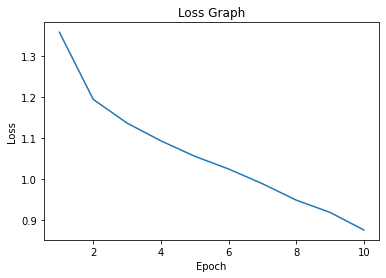

In [13]:
import time
#assert torch.cuda.is_available()
# device = 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

epochs = 10
lr = 0.0005  
batch_size = 64

val_frac = 0.1 
val_split_idx = int(len(data_file)*val_frac) 
data_idx = list(range(len(data_file)))
np.random.shuffle(data_idx)

val_idx, train_idx = data_idx[:val_split_idx], data_idx[val_split_idx:]

train_iter = data_file.iloc[train_idx].reset_index().drop('index',axis=1)
validate_iter = data_file.iloc[val_idx].reset_index().drop('index',axis=1)


train_iter = CustomTextDataset(train_iter)
validate_iter = CustomTextDataset(validate_iter)

train_dataloader = DataLoader(
    train_iter, batch_size=batch_size,
    shuffle=True, collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    validate_iter, batch_size=batch_size, 
    shuffle=False, collate_fn=collate_batch
)


num_class = 9
vocab_size = len(vocab_text)
print(vocab_size)
emsize = 120

num_heads = 8
num_trx_cells = 4

print(len(train_iter))

gradient_norm_clip = 1

model1 = TransformerBaseline(vocab_size, emsize, num_heads, 28, num_trx_cells, num_class)
loss_func = nn.functional.cross_entropy
model1 = model1.to(device)

optimizer = torch.optim.AdamW(model1.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-8)
total_accu = None
loss_value = []
epoches = []

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    running_loss = 0
    running_loss = train(model1, train_dataloader, loss_func, device, gradient_norm_clip, running_loss)
    accu_val, f1score = evaluate(model1, valid_dataloader, loss_func, device)
    loss_value.append(running_loss / len(train_iter))
    epoches.append(epoch)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} | f1 score {:8.3f}'.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val, f1score))
    print('-' * 59)
print(loss_value)
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epoches, loss_value)

# BERT + LSTM Block

In [14]:
class TransformerLSTMCell(nn.Module):

    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, dropout: float):

        super(TransformerLSTMCell, self).__init__()
        
        self.lstm = nn.LSTM(input_dim, input_dim, batch_first=True, dropout = dropout, bidirectional=True)
        self.feedfoward_layer_lstm = FeedForwardNetwork(input_dim, ff_dim, dropout)

        self.multi_attention = nn.MultiheadAttention(input_dim, num_heads, batch_first=True)
        self.dropout_layer_1 = nn.Dropout(dropout)
        self.batchnorm_layer_1 = nn.LayerNorm(input_dim)

        self.feedfoward_layer_multi = FeedForwardNetwork(input_dim, ff_dim, dropout)
        self.dropout_layer_2 = nn.Dropout(dropout)
        self.batchnorm_layer_2 = nn.LayerNorm(input_dim)

        
    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        
        y = None
        #print(x.shape)

        output1, attn_output_weights = self.multi_attention(x, x, x, mask)
        output2 = self.dropout_layer_1(output1)
        output3 = self.batchnorm_layer_1(x + output2)

        output, (ht, ct) = self.lstm(x)
        #print(x.shape[-1])
        output = output[:, :, :x.shape[-1]] + output[:, :, x.shape[-1]:]
        output = output/2.0
        #print(output.shape)
        output6 = self.feedfoward_layer_lstm(output)
        #print(output6.shape)

        #print(output3.shape)
        output4 = self.feedfoward_layer_multi(output3)
        output5 = self.dropout_layer_2(output4)
        #print(output5.shape)
        y = self.batchnorm_layer_2(output5 + (output3 + output6))
        
        return y

# BERT + BILSTM MODEL

In [15]:
class TransformerLSTM(nn.Module):
    """
    A Transformer-based text classifier.
    """
    def __init__(self, 
            vocab_size: int, embed_dim: int, num_heads: int, trx_ff_dim: int, 
            num_trx_cells: int, num_class: int, dropout: float=0.1, pad_token: int=1
        ):
        super(TransformerLSTM, self).__init__()
        
        self.embed_dim = embed_dim
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_token)
        self.positional_layer = PositionalEncoding(embed_dim)
        self.transform_layer = nn.ModuleList(TransformerLSTMCell(embed_dim, num_heads, trx_ff_dim, dropout) for i in range(num_trx_cells))
        self.output_layer = nn.Linear(embed_dim, num_class)

    def forward(self, text, mask=None):
        embedded = self.embedding(text) * math.sqrt(self.embed_dim)

        logits = None
        positional = self.positional_layer(embedded)
        for num, i in enumerate(self.transform_layer):
          positional = i(positional, mask)
        attention_output = torch.mean(positional, 1)
        logits = self.output_layer(attention_output)
        
        return logits

# Traning BERT + LSTM Model

cuda
53723
409216


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


| epoch   1 |  1000/ 6394 batches | accuracy score    0.451
| epoch   1 |  2000/ 6394 batches | accuracy score    0.543
| epoch   1 |  3000/ 6394 batches | accuracy score    0.566
| epoch   1 |  4000/ 6394 batches | accuracy score    0.581
| epoch   1 |  5000/ 6394 batches | accuracy score    0.588
| epoch   1 |  6000/ 6394 batches | accuracy score    0.593
-----------------------------------------------------------
| end of epoch   1 | time: 302.84s | valid accuracy    0.426 | f1 score    0.393
-----------------------------------------------------------
| epoch   2 |  1000/ 6394 batches | accuracy score    0.617
| epoch   2 |  2000/ 6394 batches | accuracy score    0.612
| epoch   2 |  3000/ 6394 batches | accuracy score    0.610
| epoch   2 |  4000/ 6394 batches | accuracy score    0.615
| epoch   2 |  5000/ 6394 batches | accuracy score    0.615
| epoch   2 |  6000/ 6394 batches | accuracy score    0.615
-----------------------------------------------------------
| end of epoch   2 

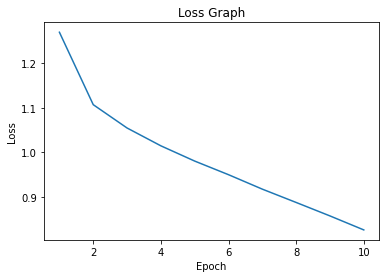

In [16]:
import time
#assert torch.cuda.is_available()
# device = 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

epochs = 10
lr = 0.0005  
batch_size = 64

val_frac = 0.1 
val_split_idx = int(len(data_file)*val_frac) 
data_idx = list(range(len(data_file)))
np.random.shuffle(data_idx)

val_idx, train_idx = data_idx[:val_split_idx], data_idx[val_split_idx:]

train_iter = data_file.iloc[train_idx].reset_index().drop('index',axis=1)
validate_iter = data_file.iloc[val_idx].reset_index().drop('index',axis=1)


train_iter = CustomTextDataset(train_iter)
validate_iter = CustomTextDataset(validate_iter)

train_dataloader = DataLoader(
    train_iter, batch_size=batch_size,
    shuffle=True, collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    validate_iter, batch_size=batch_size, 
    shuffle=False, collate_fn=collate_batch
)


num_class = 9
vocab_size = len(vocab_text)
print(vocab_size)
emsize = 120

num_heads = 8
num_trx_cells = 4

print(len(train_iter))

gradient_norm_clip = 1

model = TransformerLSTM(vocab_size, emsize, num_heads, 28, num_trx_cells, num_class)
loss_func = nn.functional.cross_entropy
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-8)
total_accu = None
loss_value_lstm = []
epoches = []

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    running_loss = 0
    running_loss = train(model, train_dataloader, loss_func, device, gradient_norm_clip, running_loss)
    accu_val2, f1score2 = evaluate(model, valid_dataloader, loss_func, device)
    loss_value_lstm.append(running_loss / len(train_iter))
    epoches.append(epoch)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} | f1 score {:8.3f}'.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val2, f1score2))
    print('-' * 59)
print(loss_value_lstm)
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epoches, loss_value_lstm)



[[1.3593056065834124, 1.1951254293774678, 1.1372049599280012, 1.0938186407051946, 1.0561111118035051, 1.02499746032756, 0.9890739785290003, 0.9488797906435464, 0.9188807864449418, 0.8759558535820997], [1.2693018901989466, 1.1069397919059434, 1.0546346986092439, 1.0146507177179145, 0.9804688905193018, 0.9499313721982695, 0.9175288663558897, 0.8876839981513133, 0.8575003875683426, 0.8261275255413476]]


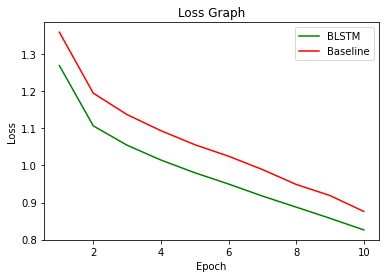

In [17]:
combined = [loss_value, loss_value_lstm]
combined_epoches = [epoches, epoches]
print(combined)
fig, ax = plt.subplots()
ax.plot(epoches, loss_value_lstm, color = 'green', label = "BLSTM")
ax.plot(epoches, loss_value, color = 'red', label = "Baseline")
plt.title('Loss Graph')
ax.legend(loc = 'upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [18]:
torch.save(model1, "/content/drive/MyDrive/Final Project/BaseModel")
torch.save(model, "/content/drive/MyDrive/Final Project/NewModel")

torch.save(vocab_text, "/content/drive/MyDrive/Final Project/Dict")